In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

color = sns.color_palette()
sns.set()

%matplotlib inline

# Структура

`orders` (3.4 млн строк, 206 тыс. пользователей):
* `order_id`: id заказа
* `user_id`: id клиента
* `eval_set`: к какому набору данных относится заказ ("SET" ниже)
* `order_number`: номер заказа в последовательности для данного пользователя (1 = первый, n = n-й)
* `order_dow`: день недели, когда был размещен заказ  (0 - Воскресенье, хотя не факт)
* `order_hour_of_day`: час дня, когда был размещен заказ (0 - полночь)
* `days_since_prior`: количество дней с последнего заказа, ограничено 30 днями (с NA для `order_number` = 1)

`products` (50 тыс. строк):
* `product_id`: id продукта
* `product_name`: название продукта
* `aisle_id`: внешний ключ
* `department_id`: внешний ключ

`aisles` (134 строки):
* `aisle_id`: id отдела
* `aisle`: название отдела

`departments` (21 строка):
* `department_id`: id подразделения
* `department`: название подразделения

`order_products__SET` (30 млн+ строк):
* `order_id`: внешний ключ
* `product_id`: внешний ключ
* `add_to_cart_order`: порядок добавления каждого продукта в корзину
* `reordered`: 1, если продукт был заказан этим пользователем ранее, 0 в противном случае

где "SET" — это одно из трех значений поля `eval_set` в таблице `orders`:
* `"prior"`: заказы до последнего заказа пользователя (~3.2 млн заказов)
* `"train"`: тренировочные данные, предоставленные участникам (~131 тыс. заказов)
* `"test"`: тестовые данные, зарезервированные для соревнований по машинному обучению (~75 тыс. заказов)

![dataset schema](assets/dataset_schema.jpg)


# Описание

## Описание заказов

In [3]:
order_products_train_df = pd.read_csv("../data/order_products__train.csv")
order_products_prior_df = pd.read_csv("../data/order_products__prior.csv")
orders_df = pd.read_csv("../data/orders.csv")
products_df = pd.read_csv("../data/products.csv")
aisles_df = pd.read_csv("../data/aisles.csv")
departments_df = pd.read_csv("../data/departments.csv")

In [4]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [82]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


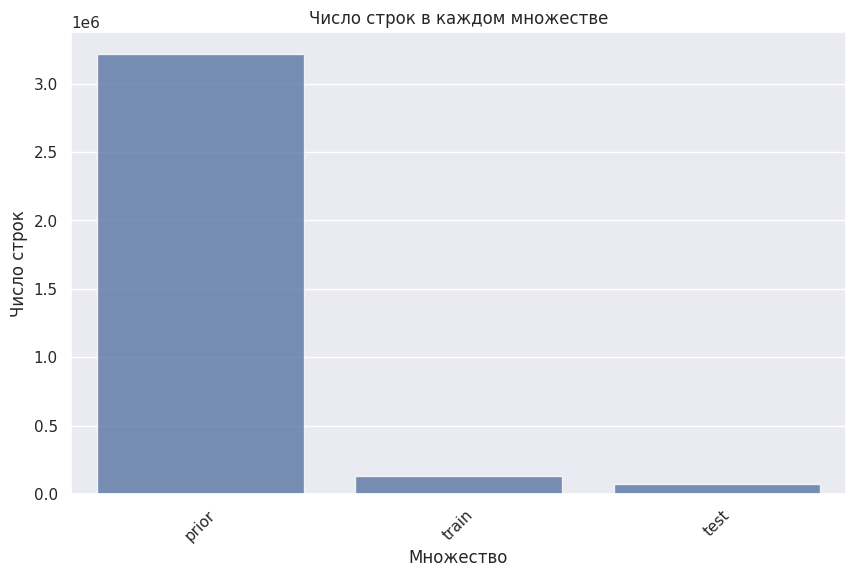

Cтрок в orders_df:
prior: 3214874
train: 131209
test : 75000

Cтрок в orders_products_prior_df:
prior: 32434489
Cтрок в orders_products_train_df:
train: 1384617


In [31]:
def plot_sizes():
    values_n = orders_df['eval_set'].value_counts()
    prior_values_n = order_products_prior_df['order_id'].size
    train_values_n = order_products_train_df['order_id'].size

    plt.figure(figsize=(10,6))
    sns.barplot(x=values_n.index, y=values_n.values, alpha=0.8)
    plt.ylabel('Число строк')
    plt.xlabel('Множество')
    plt.title('Число строк в каждом множестве')
    plt.xticks(rotation=45)
    plt.show()

    print('Cтрок в orders_df:')
    print(f'prior: {values_n.values[0]}')
    print(f'train: {values_n.values[1]}')
    print(f'test : {values_n.values[2]}')
    print()

    print('Cтрок в orders_products_prior_df:')
    print(f'prior: {prior_values_n}')

    print('Cтрок в orders_products_train_df:')
    print(f'train: {train_values_n}')

plot_sizes()

In [40]:
def get_unique_count(x):
    return len(np.unique(x))

unique_users = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
display(unique_users)

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

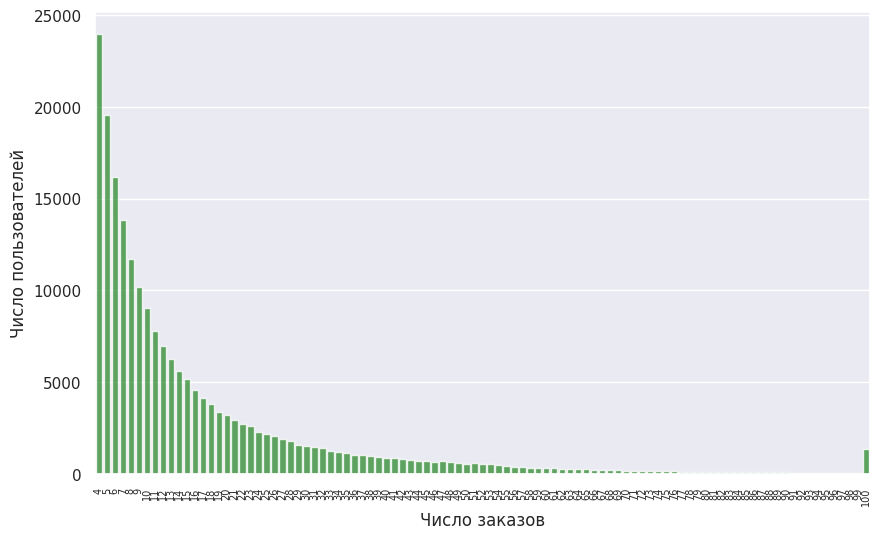

Минимальное число заказов у пользователя: 4
Максимальное число заказов у пользователя: 100


In [60]:
def plot_orders_distribution():
    orders_count = orders_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
    orders_count = orders_count["order_number"].value_counts()

    plt.figure(figsize=(10,6))
    sns.barplot(x=orders_count.index, y=orders_count.values, alpha=0.8, color=color[2])
    plt.ylabel('Число пользователей')
    plt.xlabel('Число заказов')
    plt.xticks(rotation='vertical', fontsize=7)
    plt.show()

    print(f'Минимальное число заказов у пользователя: {min(orders_count.index)}')
    print(f'Максимальное число заказов у пользователя: {max(orders_count.index)}')

plot_orders_distribution()

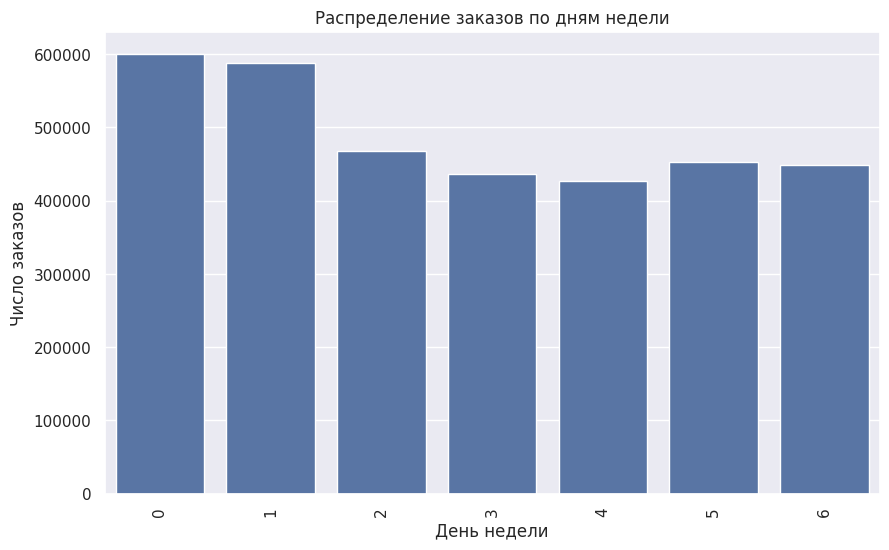

In [62]:
def dow_distribution():
    plt.figure(figsize=(10, 6))
    sns.countplot(x="order_dow", data=orders_df)
    plt.ylabel('Число заказов')
    plt.xlabel('День недели')
    plt.xticks(rotation='vertical')
    plt.title("Распределение заказов по дням недели")
    plt.show()

dow_distribution()

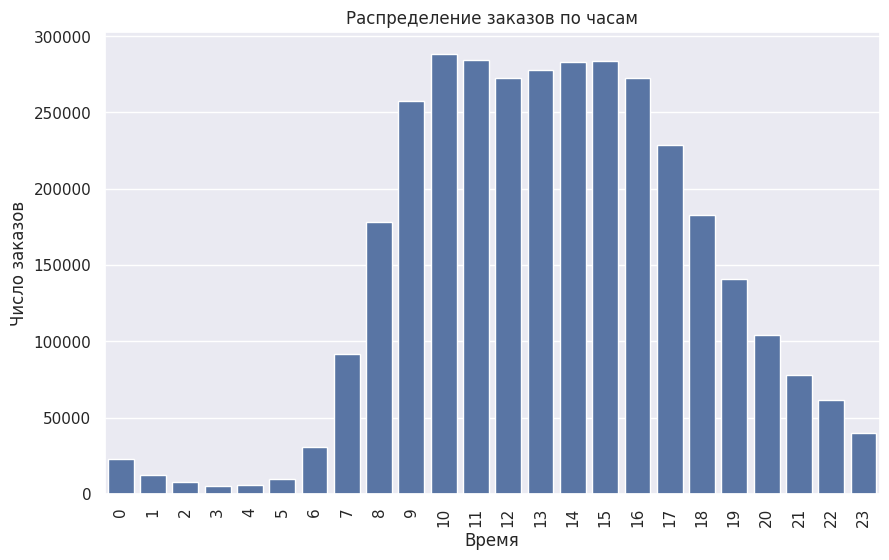

In [63]:
def time_distribution():
    plt.figure(figsize=(10, 6))
    sns.countplot(x="order_hour_of_day", data=orders_df)
    plt.ylabel('Число заказов')
    plt.xlabel('Время')
    plt.xticks(rotation='vertical')
    plt.title("Распределение заказов по часам")
    plt.show()

time_distribution()

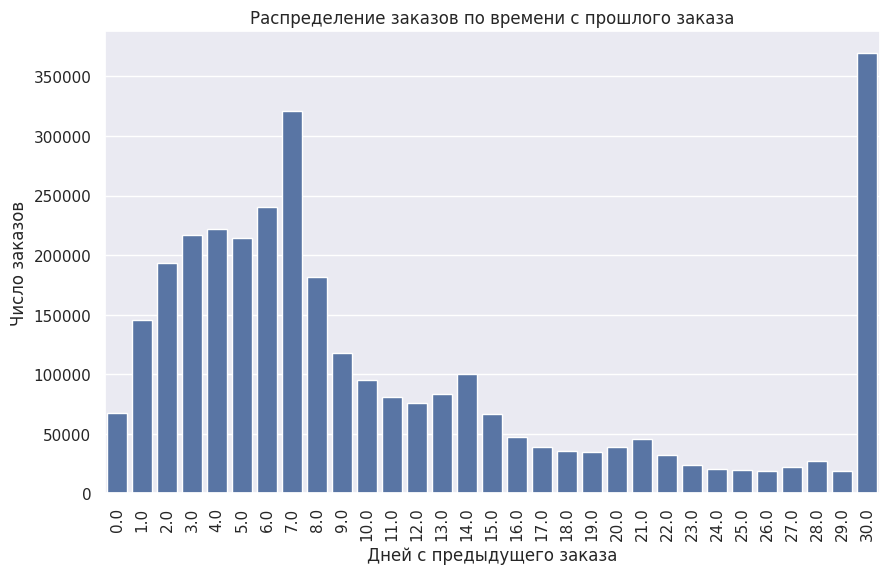

In [64]:
def prior_order_time_distribution():
    plt.figure(figsize=(10, 6))
    sns.countplot(x="days_since_prior_order", data=orders_df)
    plt.ylabel('Число заказов')
    plt.xlabel('Дней с предыдущего заказа')
    plt.xticks(rotation='vertical')
    plt.title("Распределение заказов по времени с прошлого заказа")
    plt.show()

prior_order_time_distribution()

In [96]:
prior_reordered_part = order_products_prior_df["reordered"].sum() / order_products_prior_df.shape[0]
print(f"Процент перезаказанных заказов в prior: {prior_reordered_part}")

Процент перезаказанных заказов в prior: 0.5896974667922161


In [95]:
train_reordered_part = order_products_train_df["reordered"].sum() / order_products_train_df.shape[0]
print(f"Процент перезаказанных заказов в train: {train_reordered_part}")

Процент перезаказанных заказов в train: 0.5985944127509629


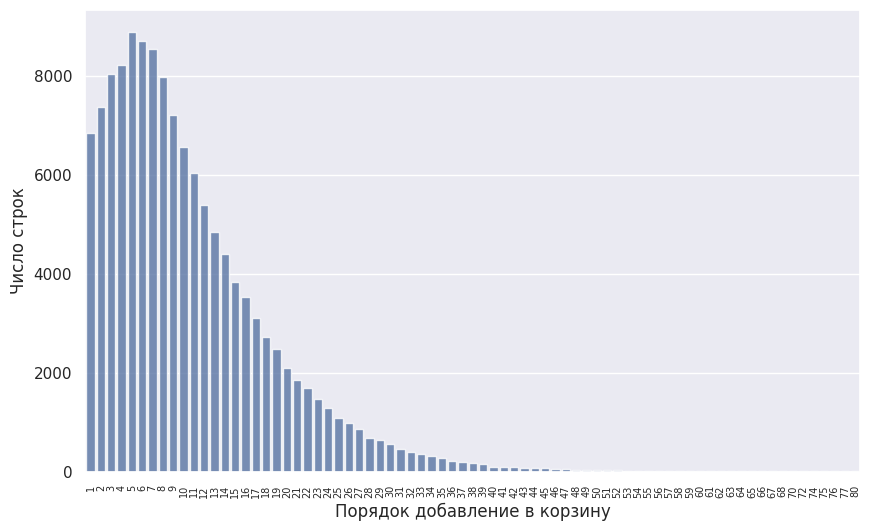

In [94]:
def plot_addition_order():
    grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
    addition_order = grouped_df["add_to_cart_order"].value_counts()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=addition_order.index, y=addition_order.values, alpha=0.8)
    plt.ylabel('Число строк')
    plt.xlabel('Порядок добавление в корзину')
    plt.xticks(rotation='vertical', fontsize=7)
    plt.show()

plot_addition_order()

## Описание продуктов

In [97]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [103]:
products_df.tail()

,product_id,product_name,aisle_id,department_id
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8
49687,49688,Fresh Foaming Cleanser,73,11


In [98]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [99]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [102]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [100]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [101]:
product_count = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
product_count.columns = ['product_name', 'frequency_count']
display(product_count)

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


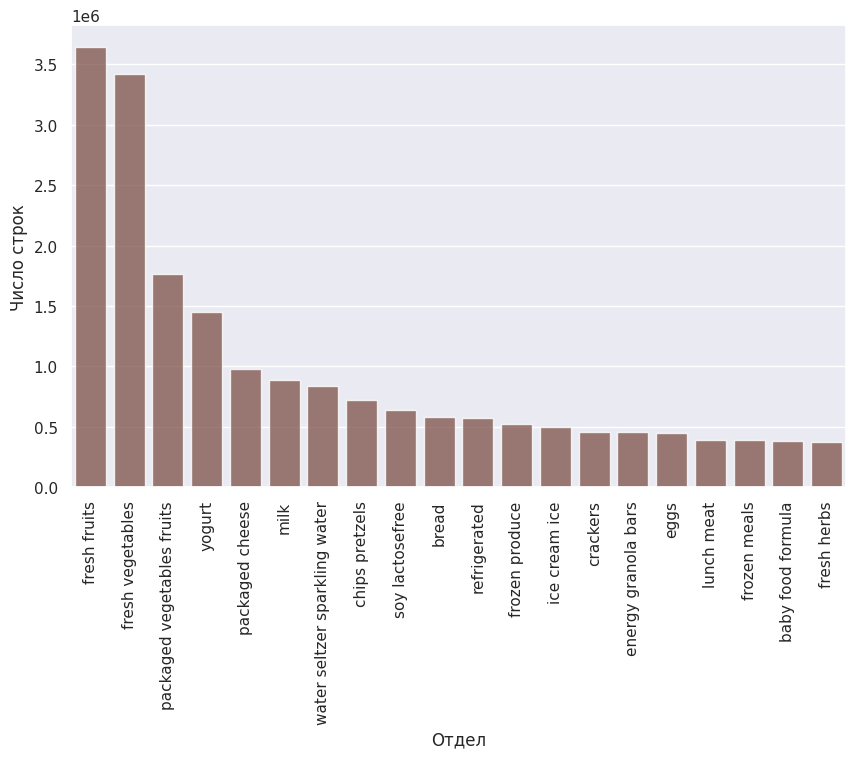

In [107]:
def plot_aisles_distribution():
    aisle_count = order_products_prior_df['aisle'].value_counts().head(20)
    plt.figure(figsize=(10,6))
    sns.barplot(x=aisle_count.index, y=aisle_count.values, alpha=0.8, color=color[5])
    plt.ylabel('Число строк')
    plt.xlabel('Отдел')
    plt.xticks(rotation='vertical')
    plt.show()

plot_aisles_distribution()

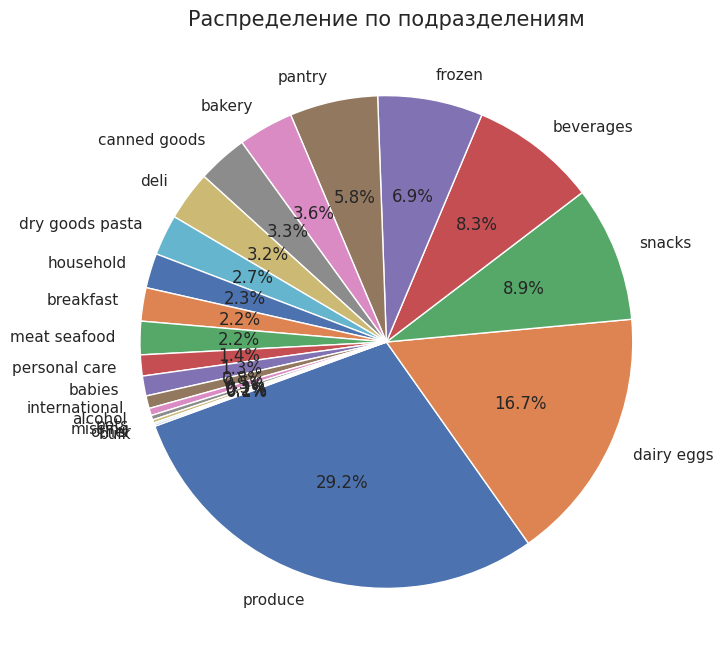

In [110]:
def plot_depatment_distibution():
    plt.figure(figsize=(8,8))
    temp_series = order_products_prior_df['department'].value_counts()
    labels = (np.array(temp_series.index))
    sizes = (np.array((temp_series / temp_series.sum())*100))
    plt.pie(sizes, labels=labels, 
            autopct='%1.1f%%', startangle=200)
    plt.title("Распределение по подразделениям", fontsize=15)
    plt.show()

plot_depatment_distibution()

In [16]:
print(orders_df['order_id'].size)
print(order_products_prior_df['order_id'].size)
print(order_products_train_df['order_id'].size)

3421083
32434489
1384617


In [9]:
orders_df.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [10]:
order_products_prior_df.describe()

,order_id,product_id,add_to_cart_order,reordered
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00
